In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import copy
import time
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
data=pd.read_csv('mnist_train.csv')
idx=np.random.choice(data.index,6000)
data=data.iloc[idx]
data.reset_index(inplace=True)
data.drop(columns='index',inplace=True)
labels=data.iloc[:,0]
data=data.iloc[:, 1:]
dataNorm=data/np.max(data,axis=0)
dataNorm.fillna(0,inplace=True)
dataT=torch.tensor(np.array(dataNorm)).float()




(-0.5, 27.5, 27.5, -0.5)

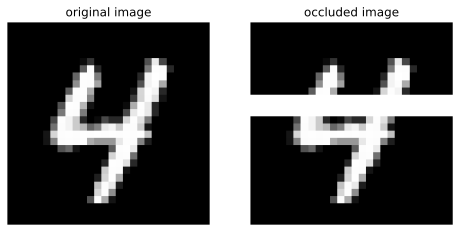

In [18]:
img=dataT[2333,:].view(28,28)
occluded=copy.deepcopy(img)
occluded[10:13,:]=1
fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('original image')
ax[0].axis('off')
ax[1].imshow(occluded,cmap='gray')
ax[1].set_title('occluded image')
ax[1].axis('off')


In [13]:
occluded

1

In [19]:
# create a class for the model
def createTheMNISTAE():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,128)
      
      ### encoder layer
      self.enc = nn.Linear(128,50)

      ### latent layer
      self.lat = nn.Linear(50,128)

      ### decoder layer
      self.dec = nn.Linear(128,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y
  
  # create the model instance
  net = aenet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [20]:
def function2trainTheModel():

  # number of epochs
  numepochs = 5
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  # initialize losses
  losses = []



  # batch size and number of batches
  batchsize  = 32
  numBatches = int(dataT.shape[0]/batchsize)


  # loop over epochs (now each epoch goes through all samples)
  for epochi in range(numepochs):

    
    # get a permuted index vector
    randidx = np.random.permutation(dataT.shape[0]).astype(int)
    
    for batchi in range(numBatches):
      
      # samples to use in this batch
      samps2use = range((batchi-1)*batchsize,batchi*batchsize)
      

      # select those images
      X = dataT[randidx[samps2use],:]

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    
      # losses in this batch
      losses.append( loss.item() )

  # end epochs
  
  # function output
  return losses,net
     

Final loss: 0.0225


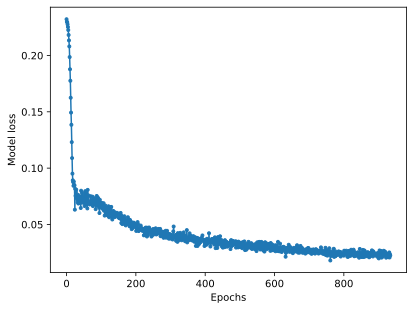

In [21]:

# train the model (16s)
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

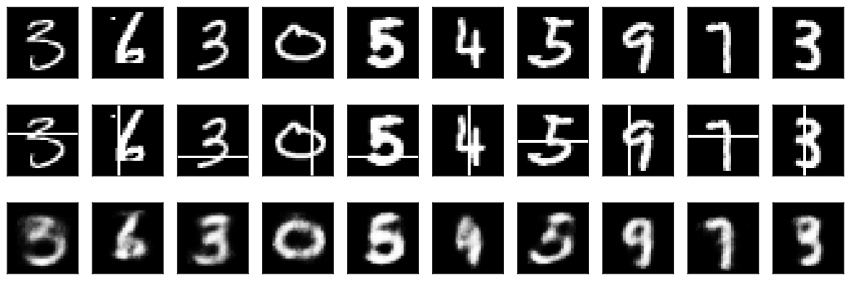

In [26]:
X=copy.deepcopy(dataT[:10,:])
for i in range(X.shape[0]):
  img=X[i,:].view(28,28)
  
  startloc=np.random.choice(range(10,21))
  if i%2==0 :
    img[startloc:startloc+1,:]=1
  else :
    img[:,startloc:startloc+1]=1
    
deOccluded=net(X)

fig,ax=plt.subplots(3,10,figsize=(15,5))

for i in range(10):
  ax[0,i].imshow(dataT[i,:].view(28,28).detach(),cmap='gray')
  ax[1,i].imshow(X[i,:].view(28,28).detach(),cmap='gray')
  ax[2,i].imshow(deOccluded[i,:].view(28,28).detach(),cmap='gray')
  ax[0,i].set_xticks([]) , ax[0,i].set_yticks([])
  ax[1,i].set_xticks([]) , ax[1,i].set_yticks([])
  ax[2,i].set_xticks([]) , ax[2,i].set_yticks([])
  
plt.show()

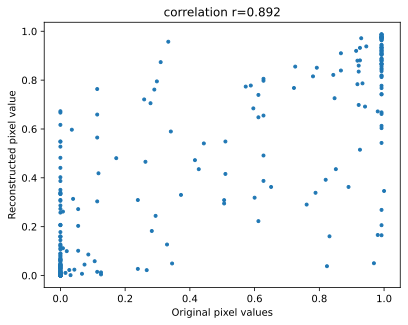

In [27]:
inOutCorr=np.corrcoef(dataT[9,:].detach(),deOccluded[9,:].detach())

plt.plot(dataT[9,:].detach(),deOccluded[9,:].detach(),'.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel value')
plt.title(f'correlation r={inOutCorr[0,1]:.3f}')
plt.show()

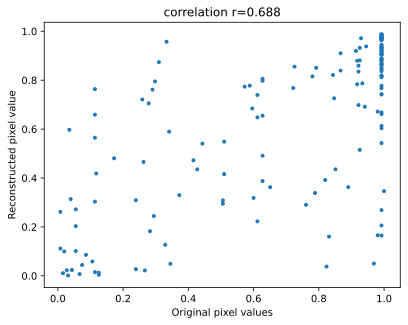

In [28]:
orig=dataT[9,:].detach()
recon=deOccluded[9,:].detach()
tol=1e-4
nonzeropixels=(orig>tol) & (recon>tol)
inOutCorr=np.corrcoef(orig[nonzeropixels],recon[nonzeropixels])

plt.plot(orig[nonzeropixels],recon[nonzeropixels],'.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel value')
plt.title(f'correlation r={inOutCorr[0,1]:.3f}')
plt.show()


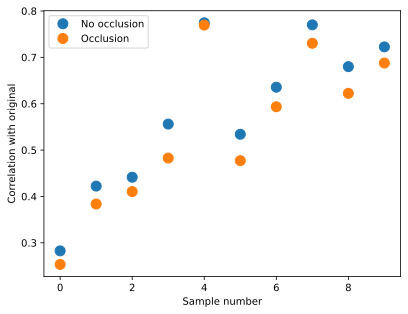

In [29]:
# get data with no occlusion
noOcclusion = net(dataT[:10,:])

# compare deOccluded-original to noOcclusion-original correlation
r = np.zeros((10,2))
for i in range(deOccluded.shape[0]):

  # pixel selection (note: tolerance defined in previous cell)
  nonzeropixels = (dataT[i,:]>tol) & (noOcclusion[i,:]>tol) & (deOccluded[i,:]>tol)

  # now compute the correlations
  r[i,0] = np.corrcoef(dataT[i,nonzeropixels].detach(),noOcclusion[i,nonzeropixels].detach())[0,1]
  r[i,1] = np.corrcoef(dataT[i,nonzeropixels].detach(),deOccluded[i,nonzeropixels].detach())[0,1]


# plot the correlation coefficients
plt.plot(r,'o',markersize=10)
plt.legend(['No occlusion','Occlusion'])
plt.xlabel('Sample number')
plt.ylabel('Correlation with original')
plt.show()

In [4]:
(1.06)**50

18.42015427499149